Github repo: https://github.com/luisdi28ms/deep_learning/tree/main/cnn

## Brief description of the problem and data

This project is about analyzing a large number of tweets (10,000) and determining based on the context if the tweet is about a real disaster ocurring or not. The problem will be addressed by training a recurrent neural network (rnn), comparing different architectures and applying the best fitted model.

* Objective: The score is evaluated as F1. 

$$ F1=2*\frac{precision * recall}{precision + recall} $$

$$ precision = \frac{TP}{TP+FP} $$

$$ recall = \frac{TP}{TP+FN} $$
    
    
* Problem Type: Binary Classification
* Dataset: A curated list of 10,000 tweets hand classified. Other than the label and tweet text, it has some features like location and keyword.

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

[FRANK MOLLARD](https://www.kaggle.com/frankmollard). (2023). NLP a Gentle Introduction (LSTM, Word2Vec, BERT). Kaggle. https://www.kaggle.com/code/frankmollard/nlp-a-gentle-introduction-lstm-word2vec-bert

**Note:** FRANK MOLLARD's notebook was used as guidance to learn about bidirectional LSTM and submiting the output to the kaggle competition. Learn more clicking the link above.

In [1]:
import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Embedding, Bidirectional
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from collections import Counter

2024-06-17 03:03:30.365942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 03:03:30.366170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 03:03:30.546701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The first step is getting rid of duplicated tweets, the keyword and location features are not guranteed in every tweet, so they were removed to reduce noise.

In [5]:
df = df.drop_duplicates("text")
df = df.drop(["keyword","location"], axis=1)

The next step is to generate training and validation splits to explore the data further.

In [6]:
train_df, val_df = train_test_split(df, test_size=.2, random_state=28)

In [7]:
train_df.target.value_counts()

target
0    3449
1    2553
Name: count, dtype: int64

Tweets have all types of special characters and symbols that don't necessary add to the discussion around emergency and disasters, so they were also removed.

In [8]:
def clean_text(text):
    # Remove non-letter characters and convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = text.lower() # turn into lowercase
    
    return text
train_df["text"] = train_df["text"].apply(clean_text)

To solve the word embedding processing, the TF-IDF method is implemented:

TF calculates the term frequency of each word in each article. 

IDF calculates the frequency of each word across all the articles. 

TF-IDF together calculate the importance of each word and assign weights to each word according to the frequency. 

The output after applying the TF-IDF function is a matrix with documents and words, the values are the assigned weights.

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=30, stop_words="english")
X = tfidf_vectorizer.fit_transform(df['text']).toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()
train_tf_idf = pd.DataFrame(X, columns=feature_names)
train_tf_idf["target"] = train_df["target"]

In [10]:
tf_idf_mean = train_tf_idf.groupby("target").agg("mean").reset_index().T.drop(["target", "http", "https"], axis=0)
tf_idf_mean.columns = ["No Disaster", "Disaster"]

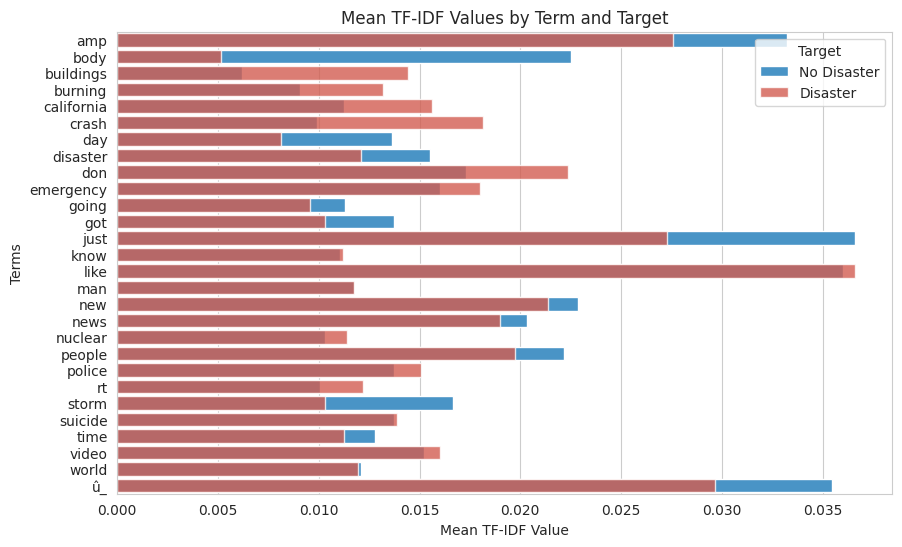

In [11]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
terms = tf_idf_mean.index
y = np.arange(len(terms))  # the label locations

# Create custom colors
color_for_0 = '#3498db'  # Blue color
color_for_1 = '#e74c3c'  # Red color

# Creating the horizontal bar chart
sns.barplot(data=tf_idf_mean, x='No Disaster', y=terms, color=color_for_0, label='No Disaster', ax=ax)
sns.barplot(data=tf_idf_mean, x='Disaster', y=terms, color=color_for_1, alpha=.8, label='Disaster', ax=ax)

# Adding labels, title and custom y-axis tick labels, etc.
ax.set_xlabel('Mean TF-IDF Value')
ax.set_ylabel('Terms')
ax.set_title('Mean TF-IDF Values by Term and Target')
ax.legend(title='Target')

# Show the plot
plt.show()

Going through the process of using a tf-idf word embedding, made me realize that LSTM won't benefit from it because tf-idf offers a whole corpus analysis and loses word sequence context. This is why a tokenizer will be used instead to take advantange of the sequential order of text in the traning of the model.

The tokenizer is fitted with the training text and it is replacing each word with its term frequency ranking instead. See below.

In [12]:
# Tokenization
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(train_df.text)
sequences = tokenizer.texts_to_sequences(train_df.text)

index_word = {i: w for w, i in tokenizer.word_index.items()}
# Detokenize sequences and count word frequencies
detokenized_texts = []
for sequence in sequences:
    words = [index_word.get(idx, '') for idx in sequence]
    detokenized_texts.extend(words)


word_counts = Counter(detokenized_texts)
print("Ranking: Word")
for index, (key, value) in enumerate(index_word.items()):
    if index < 11:
        print(f"{key}: {value}")

Ranking: Word
1: the
2: a
3: in
4: to
5: of
6: and
7: i
8: is
9: for
10: on
11: you


In [13]:
print("For sequence:")
print(sequences[0])
seq_example = []
for rank in sequences[0]:
    seq_example.append(index_word[rank])
print("\nTranslates into:")
print(seq_example)

For sequence:
[104, 61, 7, 57, 52, 3, 201, 333, 9, 550, 56, 64, 6, 1, 287, 82, 120, 5745]

Translates into:
['love', 'how', 'i', 'dont', 'get', 'in', 'any', 'trouble', 'for', 'having', 'people', 'over', 'and', 'the', 'house', 'still', 'being', 'trashed']


The last transformation needed is padding. Since each of the tweets have different length, shorter tweets need to be padded with 0's, and longer tweets might need to be trimmed to hit the right balance of information passed to the model.

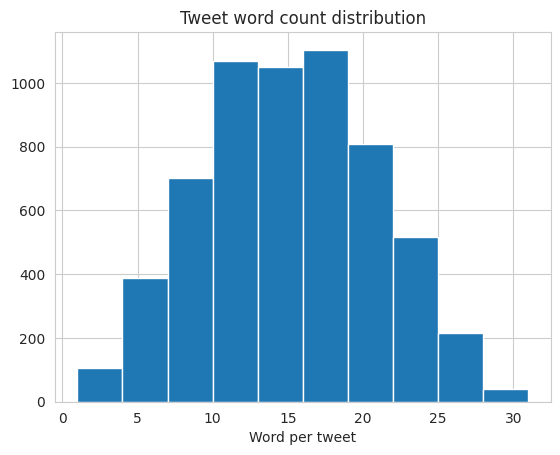

In [14]:
tweet_len = []
for seq in sequences:
    tweet_len.append(len(seq))
plt.hist(tweet_len)
plt.title("Tweet word count distribution")
plt.xlabel("Word per tweet")
plt.show()

According to the distribution, 20 seems like a good treshold.

In [15]:
sequences = tokenizer.texts_to_sequences(train_df.text)
padded_sequences = pad_sequences(sequences, maxlen=20)

To wrap up the data cleaning process, a corpus of text is cleaned by removing special characters and symbols, a tokenizer is fit to that text. That tokenizer is used to turn texts into sequences and then those sequences are padded with 0's to match a fixed input size for the model.

In [16]:
def pre_process_data(train_text, test_text):
    
    train_text = train_text.apply(clean_text)
    test_text = test_text.apply(clean_text)
    tokenizer.fit_on_texts(train_text)
    sequences = tokenizer.texts_to_sequences(test_text)
    padded_sequences = pad_sequences(sequences, maxlen=20)
    return padded_sequences, len(tokenizer.index_word)+1

## Model Architecture

Before fitting any model, a custom f1_score metric is created to train the model optimizing for the kaggle's competition metric.

In [17]:
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  
    y_pred_binary = K.round(y_pred)

    tp = K.sum(y_true * y_pred_binary, axis=0)
    fp = K.sum((1 - y_true) * y_pred_binary, axis=0)
    fn = K.sum(y_true * (1 - y_pred_binary), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1) 
    return K.mean(f1)  

The first model is a sequential LSTM with an adam optimizer.

In [18]:
x_train,input_dim = pre_process_data(train_df.text, train_df.text)
# Building the model
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=32, input_length=20))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with custom F1 score metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score])

# Train the model
x_val, input_dim = pre_process_data(train_df.text, val_df.text)
history_sequential = model.fit(x_train, train_df.target, validation_data = (x_val,val_df.target), epochs=10)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - f1_score: 0.2291 - loss: 0.6379 - val_f1_score: 0.6576 - val_loss: 0.5066
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1_score: 0.8341 - loss: 0.3109 - val_f1_score: 0.7132 - val_loss: 0.4783
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - f1_score: 0.9334 - loss: 0.1546 - val_f1_score: 0.7021 - val_loss: 0.6619
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1_score: 0.9691 - loss: 0.0683 - val_f1_score: 0.7115 - val_loss: 0.6815
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1_score: 0.9896 - loss: 0.0320 - val_f1_score: 0.7068 - val_loss: 0.8602
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - f1_score: 0.9905 - loss: 0.0323 - val_f1_score: 0.7046 - val_loss: 0.9284
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - f1_score: 0.9972 - loss: 0.0113 - val_f1_score: 0.7057 - val_loss: 0.9662
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1_score: 0.9981 - loss: 0.0076 - val_f1_s

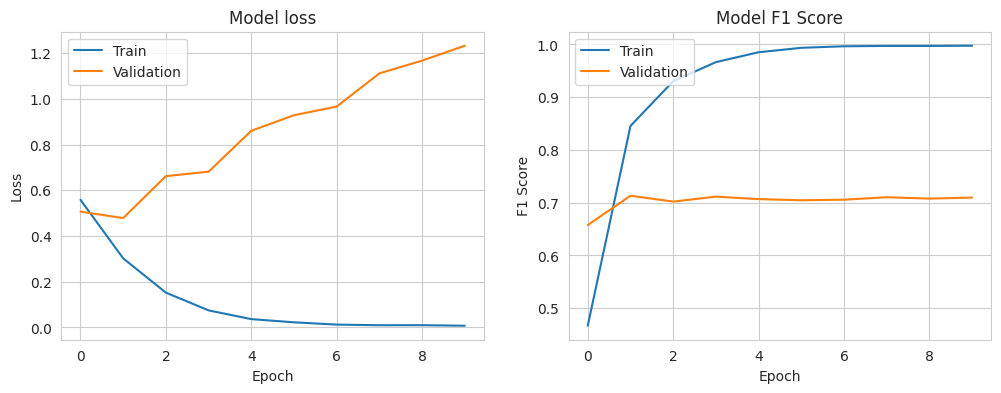

In [19]:
def model_plot(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation F1 score values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
model_plot(history_sequential)

The second model is a LSTM with bideractional layer. There is not a significant improvement from the sequential model, so the first model is prefered to maintain a more simple solution.

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - f1_score: 0.2340 - loss: 0.6307 - val_f1_score: 0.7136 - val_loss: 0.4648
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - f1_score: 0.8690 - loss: 0.2798 - val_f1_score: 0.6996 - val_loss: 0.5063
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - f1_score: 0.9567 - loss: 0.1191 - val_f1_score: 0.7106 - val_loss: 0.6729
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - f1_score: 0.9798 - loss: 0.0575 - val_f1_score: 0.6909 - val_loss: 0.8542
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - f1_score: 0.9888 - loss: 0.0301 - val_f1_score: 0.7109 - val_loss: 1.0202
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - f1_score: 0.9950 - loss: 0.0134 - val_f1_score: 0.6904 - val_loss: 1.0612
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - f1_score: 0.9958 - loss: 0.0130 - val_f1_score: 0.7052 - val_loss: 1.1330
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - f1_score: 0.9946 - loss: 0.0120 - val_f1_s

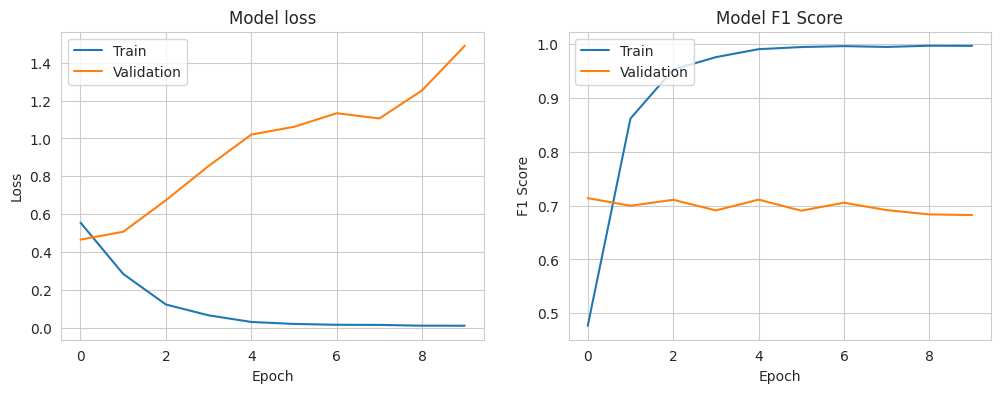

In [20]:
x_train,input_dim = pre_process_data(train_df.text, train_df.text)
# Building the model
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=32, input_length=20))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with custom F1 score metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score])

# Train the model
x_val, input_dim = pre_process_data(train_df.text, val_df.text)
history_bidirectional = model.fit(x_train, train_df.target, validation_data = (x_val,val_df.target), epochs=10)
model_plot(history_bidirectional)

## Results and Analysis

Finally, a full model is trained using the complete training dataset. Since there were no improvements trying different parameters, adding a dropout and activation functions, the final model is just a sequential LSTM.

In [21]:
x_train,input_dim = pre_process_data(df.text, df.text)
# Building the model
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=32, input_length=20))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with custom F1 score metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score])

# Train the model
history = model.fit(x_train, df.target, epochs=10)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - f1_score: 0.2296 - loss: 0.6251
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.8412 - loss: 0.3003
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_score: 0.9321 - loss: 0.1489
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.9670 - loss: 0.0737
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.9880 - loss: 0.0353
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.9906 - loss: 0.0214
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.9954 - loss: 0.0147
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.9949 - loss: 0.0138
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.9961 - loss: 0.0087
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.9956 - loss: 0.0091


In [22]:
x_test,input_dim = pre_process_data(df.text, test_df.text)
preds = model.predict(x_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [23]:
subm = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
subm["target"] = [1 if i > 0.5 else 0 for i in preds]
subm.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [24]:
subm.to_csv("Submission_Basic.csv", index=False)

![score](rnn_score.png)

## Conclusion

In this specific usecase, the LSTM model did not perform as well as other methods. Based on my review of other kaggle users, models like BERT and Glove embeddings outperform LSTM. It seems extracting context from text is not one of this model strengths, it'd be interesting to measure its performance on more sequential expected patterns like time series analysis.

Github repo: https://github.com/luisdi28ms/deep_learning/tree/main/cnn